In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import cv2

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

acT1_complex = np.load(r"C:\Users\Timothy\Desktop\数学建模相关\二轮\数据集\data_amplitude_T1_complex.npy")
df = pd.DataFrame(acT1_complex)

##### 原图展示

In [5]:
plt.figure(figsize=(10, 6))
Pxx, freqs, bins, im = plt.specgram(df.iloc[445], NFFT=1024, Fs=1, noverlap=500, cmap='jet')
plt.ylim(-0.3, 0.3)
plt.colorbar()
plt.xlabel('脉冲数')
plt.ylabel('频率')
plt.title('原始频谱图')
plt.savefig('original.png')
plt.close()

##### 一次去噪+特异性滤波

In [6]:
# 对Pxx应用高斯滤波
Pxx_filtered = gaussian_filter(Pxx, sigma=0.1)
# 保存原来的颜色映射
vmin = np.min(10 * np.log10(Pxx_filtered))
vmax = np.max(10 * np.log10(Pxx_filtered))
norm = Normalize(vmin=vmin, vmax=vmax)
# 特异性抑制
index = np.where((freqs >= 0.03) & (freqs <= 0.2))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
suppress_func = 1 - sigmoid(Pxx_filtered[index]/500000000) # 计算抑制函数
Pxx_filtered[index] = Pxx_filtered[index] * suppress_func

# 保存原图像
plt.figure(figsize=(10, 6))
plt.pcolormesh(bins, freqs, 10 * np.log10(Pxx_filtered), cmap='jet', norm=norm)
plt.ylim(-0.3, 0.3)
plt.colorbar()
plt.xlabel('脉冲数')
plt.ylabel('频率')
plt.title('频谱图')
plt.savefig('p1.png')
plt.close()

C:\Users\Timothy\AppData\Local\Temp\ipykernel_8492\1210175391.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(bins, freqs, 10 * np.log10(Pxx_filtered), cmap='jet', norm=norm)


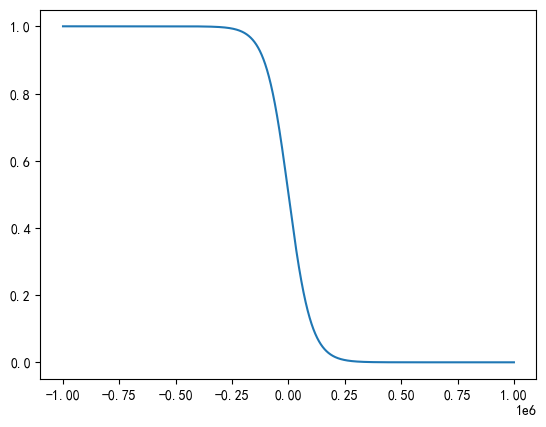

In [20]:
x = np.linspace(-1000000, 1000000, 102400)
y = 1 - sigmoid(x/50000)

plt.plot(x, y)
plt.show()

##### 二次去噪（OpenCV）

In [34]:
img = cv2.imread('p1.png')
dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
cv2.imwrite('p2.png', dst)

True

##### 轮廓提取（二值图）

In [35]:
# 读取图像，并确定处理区域
img = dst
roi = img[:, :700]

# 提取红色区域
hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
lower_red = np.array([0, 70, 50])
upper_red = np.array([10, 255, 255])

# 查找轮廓
mask = cv2.inRange(hsv, lower_red, upper_red)
res = cv2.bitwise_and(roi, roi, mask=mask)
gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY) # 将图像转换为灰度图
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY) # 应用阈值操作，将图像转换为二值
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 在图像上绘制轮廓并保存
cv2.drawContours(img, contours, -1, (255, 255, 255), 3)
cv2.imwrite('p31.png', img)
# 绘制二值图像并保存
new_img = np.zeros_like(img) # 创建一个与img相同大小的全黑图像
cv2.drawContours(new_img, contours, -1, (255, 255, 255), 3)
cv2.imwrite('p32.png', new_img)

True

##### 分类

In [36]:
# 将图像的像素值除以255，得到0和1的矩阵
binary_matrix = gray / 255
# 打印矩阵
print(img.shape)
print(np.sum(binary_matrix))

(600, 1000, 3)
221.72156862745098
